<a href="https://colab.research.google.com/github/hooked-on-mas/AutoGenBook/blob/main/AutoGenBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [1]:
# @markdown ## Required Fields
# @markdown ### Content of the Textbook
book_content = "A textbook on linear algebra related to machine learning" #@param {type:"string"}
# @markdown ### Approximate Number of Pages
n_pages = 40 # @param {"type":"integer","placeholder":"40"}
# @markdown ### Output Format
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = True #@param {type:"boolean"}

# @markdown ## Optional Fields
# @markdown ### Intended Audience
target_readers = "A fourth-year university student who is already familiar with Python and Numpy and has started research on machine learning this year." #@param {type:"string"}
# @markdown ### Frequency of Equations
equation_frequency_level = 4 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### Consider Chapter Structure and Organization in Content Generation
do_consider_outline = True #@param {type:"boolean"}
# @markdown ### Consider Previous Output in Content Generation
do_consider_previous_sections = True #@param {type:"boolean"}
# @markdown ### Additional Requirements for Content
additional_requirements = "After explaining the theory, please include examples of calculations using Numpy." #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'Please specify the content of the textbook.'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'Please specify the number of pages.'+'\033[0m')

## Prompt Definition

In [2]:
# Common Prompt
prompt_common = f"""
The following content will be used to write a book.
{book_content}
The total number of pages in the book is {n_pages}, with an estimated 40 lines per page. Please write in a polite tone.
"""
if target_readers != "":
    prompt_common += f"The intended readers are as follows:\n {target_readers}"
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed.
```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like to create content across {n_pages} pages, assuming 40 lines per page.
The summary for this section is as follows:
{section_summary}
Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles.
```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """
Based on the above, I would like to create a book titled {book_title}. The book summary is as follows:
{book_summary}
I would like to create content for the section on {target}, across {n_pages} pages, assuming 40 lines per page.
The summary for this section is as follows:
{section_summary}
{toc_and_summary}
{previous_sections}
Please output the content for {n_pages} pages, i.e., {n_pages} × 40 lines, in LaTeX format. All necessary libraries have been imported in the preamble.
Please do not include speculative or unverified information. Only output the main content without headings.
{equation_frequency}
For equations, use the equation or align environment; avoid using any other environments.
Ensure no nested equations are used, i.e., use \\begin{{align}} \\end{{align}} instead of \\[ \\begin{{align}} \\end{{align}} \\].
For programming code, use the lstlisting environment, setting only the programming language as an option. For instance, if the language is Python, use \\begin{{lstlisting}}[language=Python].
Whenever using #, please escape it as \#.
The output format should be as follows:
```tex
Main content
```
"""

## Parameter Settings

In [3]:
# Parameters
max_depth = 5  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

openai_api_secret_key_name = 'openai_api'  # Variable name when registering openai_api as a secret key
model_name = "gpt-4o"  # Model name

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

## Library Installation and Import

In [4]:
!apt-get update
!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
!apt-get install -y latexmk
!apt-get install -y texlive-latex-extra
!apt-get install -y texlive-science
%pip install -qU langchain-openai
%pip install pygraphviz
%pip install pylatex

import os
import re
import json
import networkx as nx
from google.colab import userdata
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from google.colab import files

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

## Graph Creation

In [5]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

## Title and Chapter Creation

### Function Definition

In [6]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
              # Convert to JSON format
              json_data = json.loads(json_string)
              return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [7]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get(openai_api_secret_key_name)

llm = ChatOpenAI(model="gpt-4o")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
    }
)

book_json = extract_book_and_chapter_contents(result.content)

### Storing Results in the Book Graph

In [8]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [9]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)



 ## Title: Linear Algebra for Machine Learning: A Practical Guide with Numpy (Page Count: 40)
 This textbook serves as a comprehensive introduction to linear algebra with a focus on its applications in machine learning, tailored for fourth-year university students. The book bridges theoretical concepts with practical applications, providing readers with a solid foundation to understand and implement machine learning algorithms. Each chapter integrates Python and Numpy examples to demonstrate the calculations and concepts discussed, fostering a hands-on learning experience. The content is structured to progressively build knowledge, from fundamental principles to more complex topics, ensuring that readers develop both theoretical understanding and practical skills. By the end of the book, students will be equipped to apply linear algebra techniques to enhance their machine learning research and projects. The concise format ensures key concepts are covered efficiently, making it an ideal resource for students eager to advance their understanding of machine learning.
 ### Chapter 1: Introduction to Linear Algebra in Machine Learning (Page Count: 5.0)
This chapter introduces the fundamental concepts of linear algebra, emphasizing their importance in machine learning. It sets the stage by discussing vectors, matrices, and their roles in data representation and manipulation. Basic operations such as addition, subtraction, and multiplication are covered, with examples highlighting their significance in machine learning contexts. This chapter aims to provide a solid foundation, ensuring readers are comfortable with the basic terminologies and operations before delving deeper into more advanced topics.
 ### Chapter 2: Vector Spaces and Subspaces (Page Count: 6.0)
This chapter explores the concept of vector spaces and subspaces, which are pivotal in understanding the structure and behavior of datasets in machine learning. It delves into the properties and significance of these spaces, including linear independence, bases, and dimension. Practical examples using Numpy will illustrate how to work with vector spaces, providing readers with the tools to conceptualize and manipulate data effectively in machine learning scenarios.
 ### Chapter 3: Matrix Transformations and Applications (Page Count: 7.0)
Focusing on matrix transformations, this chapter examines how matrices can be used to perform linear transformations, which are essential for various machine learning techniques. Topics include eigenvalues, eigenvectors, and diagonalization, with practical examples demonstrating their application in dimensionality reduction and data compression. Numpy-based examples will help solidify understanding, enabling readers to apply these concepts to real-world machine learning tasks.
 ### Chapter 4: Solving Linear Systems (Page Count: 5.5)
This chapter addresses the methods for solving linear systems of equations, a critical aspect in training machine learning models. It covers Gaussian elimination, LU decomposition, and iterative methods, providing a blend of theory and practice. Readers will learn how to implement these techniques using Numpy, gaining the ability to solve linear systems efficiently—an essential skill for optimizing machine learning algorithms.
 ### Chapter 5: Inner Products and Norms (Page Count: 4.5)
Exploring the concepts of inner products and norms, this chapter discusses their importance in measuring similarity and distance between data points, which are fundamental in clustering and classification tasks. The chapter includes definitions, properties, and examples of different norms, followed by practical exercises using Numpy to compute these metrics in machine learning applications.
 ### Chapter 6: Singular Value Decomposition (SVD) (Page Count: 6.0)
Singular Value Decomposition (SVD) is introduced as a powerful matrix factorization technique with applications in machine learning, such as data compression and noise reduction. The chapter provides a thorough explanation of SVD, its derivation, and practical implications, complemented by Numpy examples. Readers will learn how to apply SVD to enhance the performance and efficiency of their machine learning models.
 ### Chapter 7: Practical Applications of Linear Algebra in Machine Learning (Page Count: 6.0)
The final chapter consolidates the concepts covered throughout the book, showcasing their practical applications in machine learning projects. It includes examples of linear regression, principal component analysis, and support vector machines, illustrating how linear algebra underpins these algorithms. By implementing these examples using Numpy, readers will gain confidence in applying linear algebra techniques to enhance their machine learning research.

## Book Graph Creation

### Function Definition

In [10]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

def extract_section_content(markdown_text):

    pattern = r'```tex\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        tex_string = match.group(1)
        return tex_string
    else:
        print("TeX data not found.")
        return None

def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLMによる章立ての出力

In [11]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]


            if (child_node["needsSubdivision"] or child_node["n_pages"] >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result.content)

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                # Only set as the next parent if subdivided
                next_parent_list.append(child_node_name)

            elif not child_node["needsSubdivision"] or depth == max_depth-1:

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

### 本文の内容の出力

#### 関数定義

In [12]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The chapter structure is shown below.\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, content, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "content": content}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        content = i_previous_section["content"]
        prompt += f"The title of part {i+1} sections ago is {title}, and the content is as follows.\n{content}\n"

    return prompt

#### 本文出力

In [16]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "", "content": ""} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"]
        }
    )

    # Save output to file
    contents_tex = extract_section_content(result.content)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], contents_tex, previous_sections_content_list)

## 本グラフの表示

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


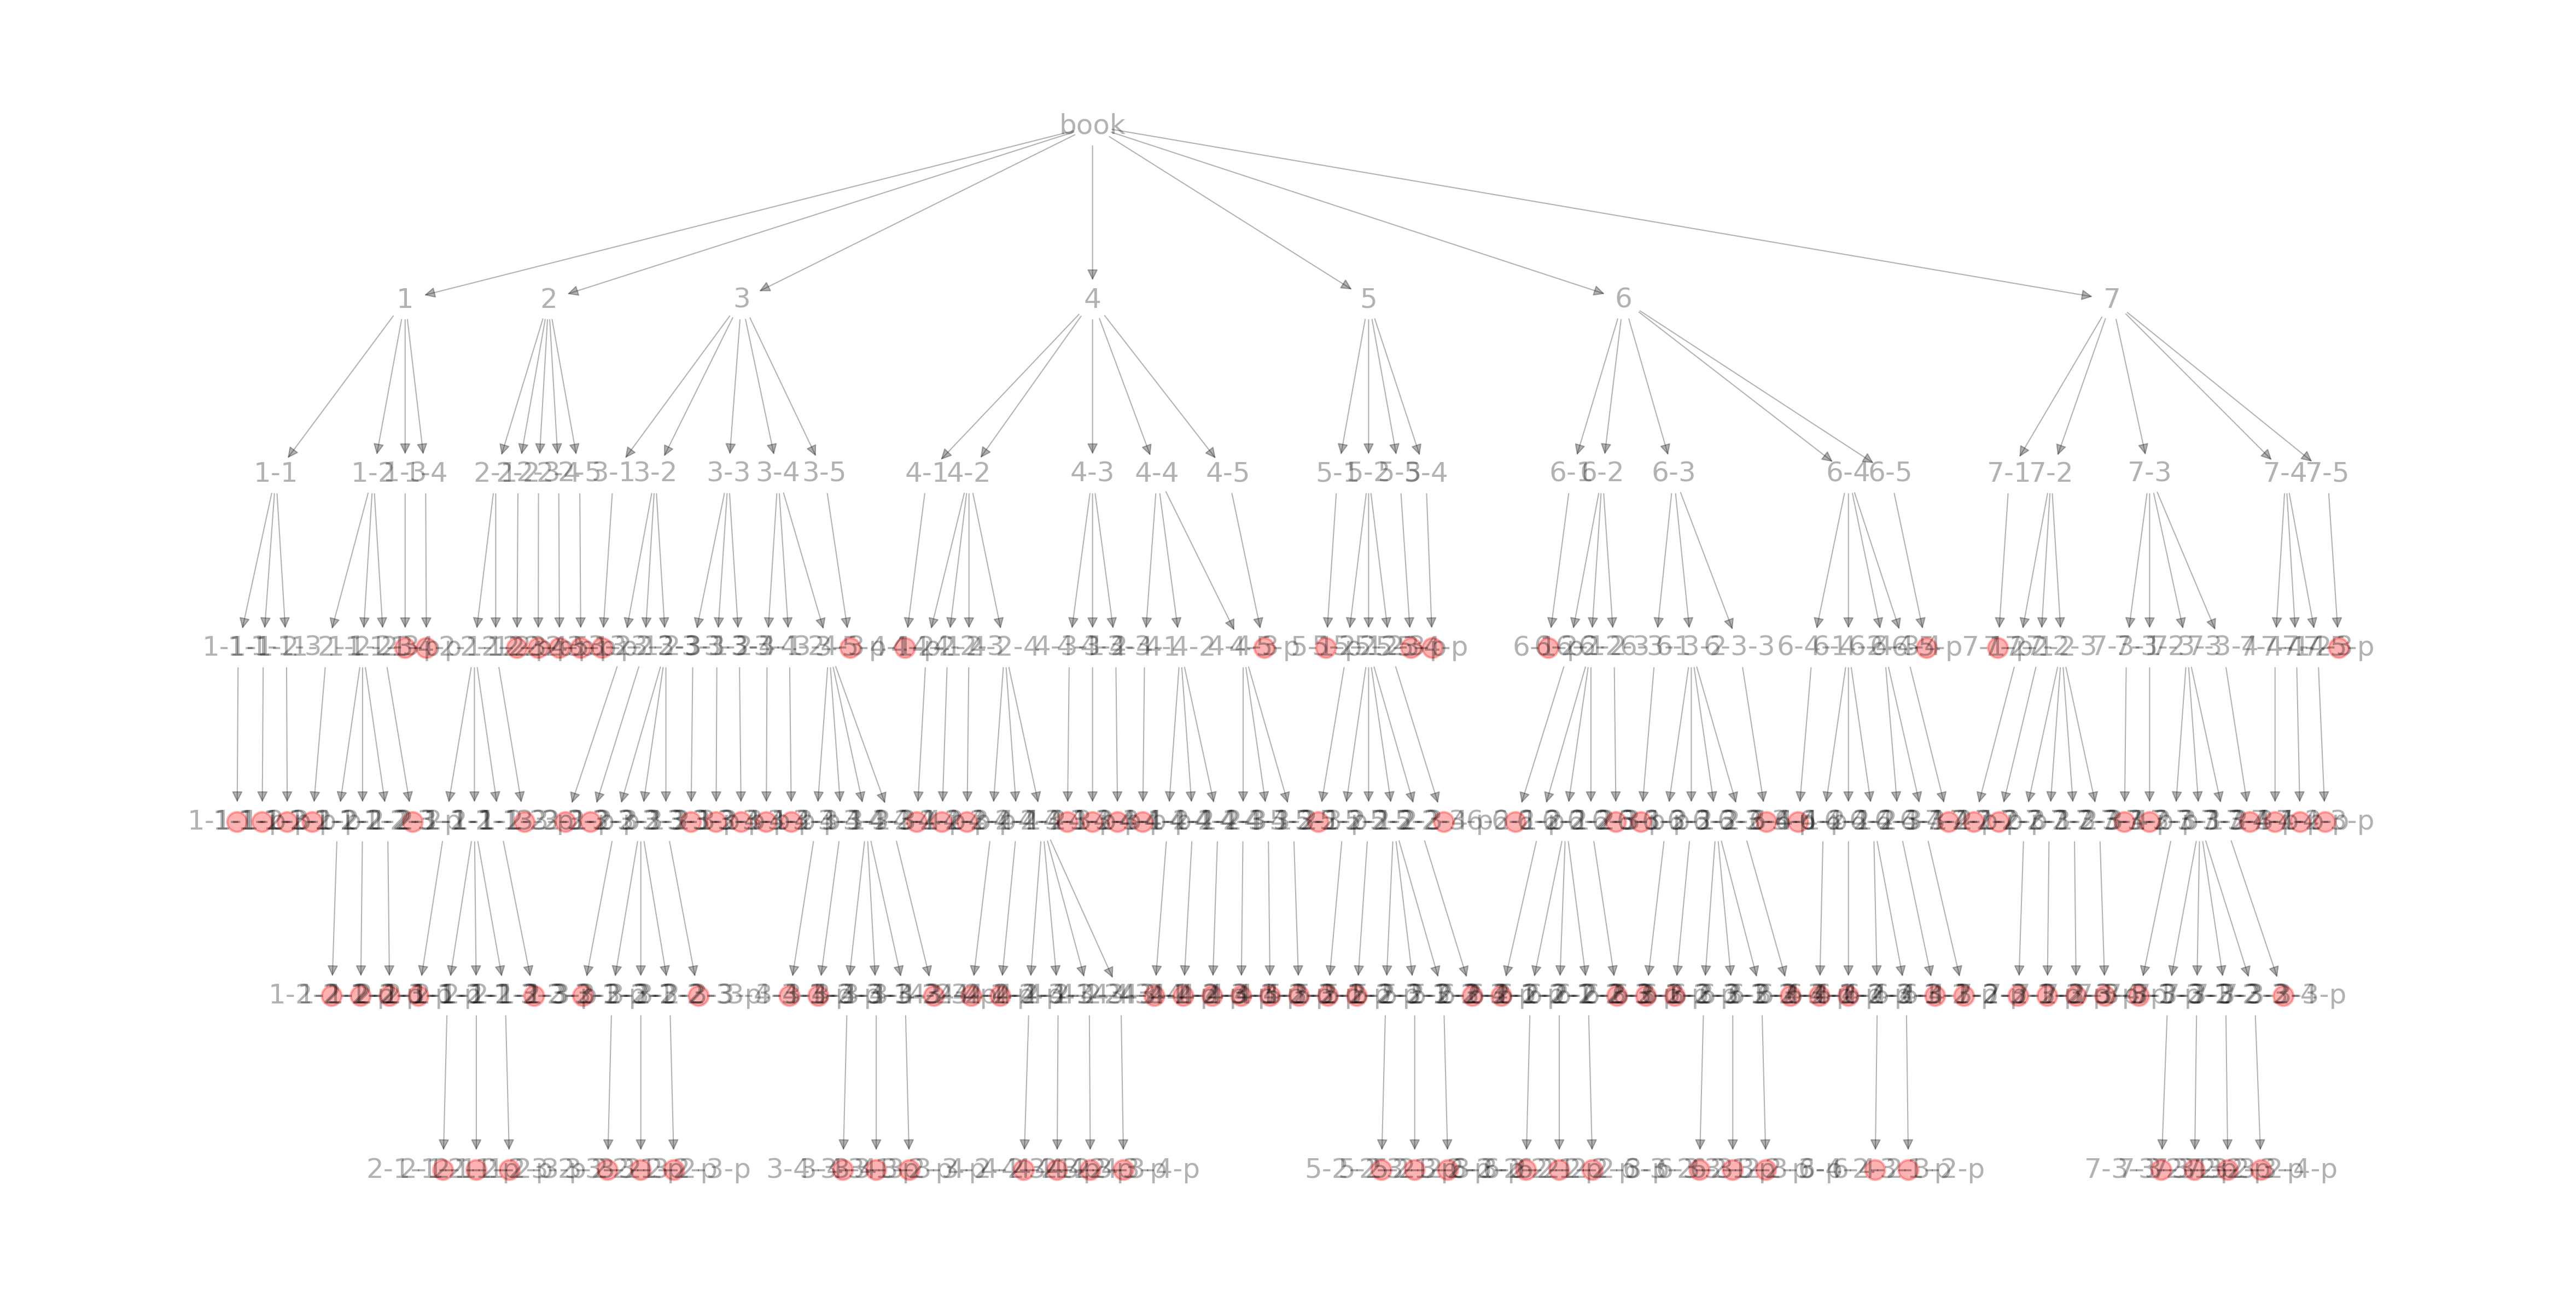

In [17]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## 本の作成

### latexmkrcファイルの作成

In [18]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

.latexmkrc file has been created successfully at /root/.latexmkrc


### LaTeXで本文の作成

### LaTeXドキュメントの作成

In [19]:
# Creating a PDF using pylatex
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("date", NoEscape(r"\today")))
doc.append(NoEscape(r"\maketitle"))
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r'\lstset{ backgroundcolor={\color[gray]{.90}}, breaklines = true, breakindent = 10pt, basicstyle = \ttfamily\scriptsize, commentstyle = {\itshape \color[cmyk]{1,0.4,1,0}}, classoffset = 0, keywordstyle = {\bfseries \color[cmyk]{0,1,0,0}}, stringstyle = {\ttfamily \color[rgb]{0,0,1}}, frame = TBrl, framesep = 5pt, numbers = left, stepnumber = 1, numberstyle = \tiny, tabsize = 4, captionpos = t}'))

In [20]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    with open(tex_file_path, "r", encoding='UTF-8') as file:
        tex_content = file.read()
        doc.append(NoEscape(tex_content))

### PDFファイルの作成

In [21]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = "/content/" + book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

if isErrorOccured:
    files.download("/content/" + book_node["title"] + ".tex")
    raise Exception("An error occurred while compiling the TeX file. Please run it again or refer to the error details above and try compiling after correcting the errors.")

Rc files read:
  /etc/LatexMk
  /root/.latexmkrc
Latexmk: This is Latexmk, John Collins, 20 November 2021, version: 4.76.
Rule 'pdflatex': File changes, etc:
   Changed files, or newly in use since previous run(s):
      '/content/Linear Algebra for Machine Learning: A Practical Guide with Numpy.tex'
------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  --interaction=nonstopmode -recorder  "/content/Linear Algebra for Machine Learning: A Practical Guide with Numpy.tex"'
------------
Latexmk: applying rule 'pdflatex'...
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/content/Linear Algebra for Machine Learning: A Practical Guide with Numpy.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/report.cls
Document Class: report 2021/10/04 v1.4n Standard LaTeX document class
(/usr/

In [22]:
# Download
if tex_output:
    files.download("/content/" + book_node["title"] + ".tex")

if pdf_output:
    files.download("/content/" + book_node["title"] + ".pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Markdownファイルの作成

In [23]:
def clean_markdown_content(content):
    # Remove the part before the first heading (LaTeX settings section)
    content = content.split('#', 1)[1]

    # Remove % only when it has whitespace before or after
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # Remove % only when it appears at the end of a line
    content = re.sub(r"%\s*$", "", content)

    # Replace multiple newlines with a single newline
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # Convert align and align* environments
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # Convert equation and equation* environments
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # Extract and handle language option
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # Search for language option
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # Convert to Markdown format
        return f'```{lang}\n{code}\n```'

    # Conversion process for lstlisting
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [24]:
if md_output:
    %pip install latex2markdown
    import latex2markdown

    with open("/content/" + book_node["title"] + ".tex", "r") as f:
        latex_string = f.read()

    # Convert LaTeX to Markdown
    processed_latex_str = transform_code_blocks(latex_string)
    l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
    markdown_string = l2m.to_markdown()

    # Format the Markdown text
    cleaned_md_str = clean_markdown_content(markdown_string)
    katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

    with open("/content/" + book_node["title"] + ".md", "w") as f:
        f.write(katex_md_str)
    files.download("/content/" + book_node["title"] + ".md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>